In [2]:
import pandas as pd


bank_df = pd.read_csv( 'bank.csv')
bank_df.head(5)

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [3]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                4521 non-null   int64 
 1   job                4521 non-null   object
 2   marital            4521 non-null   object
 3   education          4521 non-null   object
 4   default            4521 non-null   object
 5   balance            4521 non-null   int64 
 6   housing-loan       4521 non-null   object
 7   personal-loan      4521 non-null   object
 8   current-campaign   4521 non-null   int64 
 9   previous-campaign  4521 non-null   int64 
 10  subscribed         4521 non-null   object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


## Dealing with imbalanced datasets

In [4]:
bank_df.subscribed.value_counts()

no     4000
yes     521
Name: subscribed, dtype: int64

In [5]:
## Importing resample from *sklearn.utils* package.
from sklearn.utils import resample

# Separate the case of yes-subscribes and no-subscribes
bank_subscribed_no = bank_df[bank_df.subscribed == 'no']
bank_subscribed_yes = bank_df[bank_df.subscribed == 'yes']

##Upsample the yes-subscribed cases.
df_minority_upsampled = resample(bank_subscribed_yes,
replace=True, # sample with replacement
n_samples=2000)

# Combine majority class with upsampled minority class
new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled])

#### Advanced Techniques

https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/

In [6]:
from sklearn.utils import shuffle
new_bank_df = shuffle(new_bank_df)

In [7]:
# Assigning list of all column names in the DataFrame
X_features = list( new_bank_df.columns )
# Remove the response variable from the list
X_features.remove( 'subscribed' )
X_features

['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [8]:
## get_dummies() will convert all the columns with data type as objects
encoded_bank_df = pd.get_dummies( new_bank_df[X_features], drop_first = True )
X = encoded_bank_df

In [9]:
# Encoding the subscribed column and assigning to Y
Y = new_bank_df.subscribed.map( lambda x: int( x == 'yes') )

In [10]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split( X, Y, test_size = 0.3, random_state = 42 )

## ROC Curve

In [21]:
from sklearn import metrics
import matplotlib.pyplot as plt

## The method takes the three following parameters
## model: the classification model
## test_X: X features of the test set
## test_y: actual labels of the test set
## Returns
## - ROC Auc Score
## - FPR and TPRs for different threshold values
def draw_roc_curve( model, test_X, test_y ):
    ## Creating and initializing a results DataFrame with actual labels
    test_results_df = pd.DataFrame( { 'actual': test_y } )
    test_results_df = test_results_df.reset_index()
    # predict the probabilities on the test set
    predict_proba_df = pd.DataFrame( model.predict_proba( test_X ) )
    ## selecting the probabilities that the test example belongs to class 1
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2]
    ## Invoke roc_curve() to return the fpr, tpr and threshold values.
    ## threshold values contain values from 0.0 to 1.0
    fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual, test_results_df.chd_1, drop_intermediate = False )
    ## Getting the roc auc score by invoking metrics.roc_auc_score method
    auc_score = metrics.roc_auc_score( test_results_df.actual, test_results_df.chd_1 )
    ## Setting the size of the plot
    plt.figure(figsize=(8, 6))
    ## plotting the actual fpr and tpr values
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    ## plotting th diagnoal line from (0,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ## Setting labels and titles
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return auc_score, fpr, tpr, thresholds

## KNN Algorithm

In [22]:
## Importing the KNN classifier algorithm
from sklearn.neighbors import KNeighborsClassifier
## Initializing the classifier
knn_clf = KNeighborsClassifier()
## Fitting the model with the training set
knn_clf.fit( train_X, train_y )

KNeighborsClassifier()

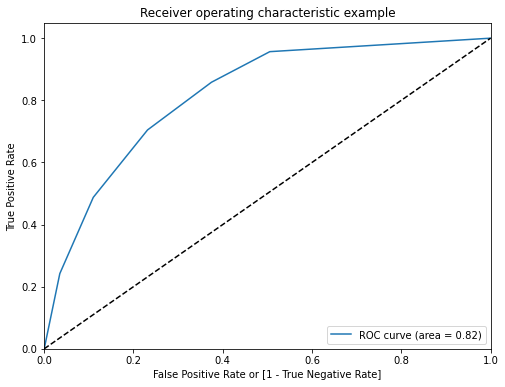

In [23]:
## Invoking draw_roc_curve with the KNN model
_, _, _, _ = draw_roc_curve( knn_clf, test_X, test_y )

In [32]:
## Importing the metrics

import seaborn as sn

## Defining the matrix to draw the confusion metrix from actual and predicted class labels
def draw_cm( actual, predicted ):
    # Invoking confusion_matrix from metric package. The matrix will oriented as [1,0] i.e.
    # the classes with label 1 will be reprensted the first row and 0 as second row
    cm = metrics.confusion_matrix( actual, predicted ) #, [1,0]
    ## Confustion will be plotted as heatmap for better visualization
    ## The lables are configured to better interpretation from the plot
    sn.heatmap(cm, annot=True, fmt='.2f',
    xticklabels = ["Subscribed", "Not Subscribed"] ,
    yticklabels = ["Subscribed", "Not Subscribed"] )
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

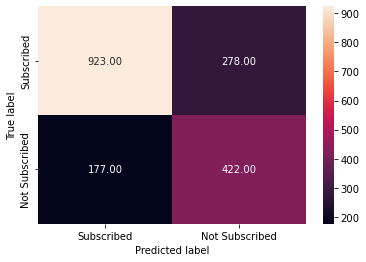

In [33]:
## Predicting on test set
pred_y = knn_clf.predict(test_X)
## Drawing the confusion matrix for KNN model
draw_cm( test_y, pred_y )

In [34]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1201
           1       0.60      0.70      0.65       599

    accuracy                           0.75      1800
   macro avg       0.72      0.74      0.73      1800
weighted avg       0.76      0.75      0.75      1800



In [35]:
## Importing GridSearchCV
from sklearn.model_selection import GridSearchCV
## Creating a dictionary with hyperparameters and possible values for searching
tuned_parameters = [{'n_neighbors': range(5,10),
'metric': ['canberra', 'euclidean', 'minkowski']}]
## Configuring grid search
clf = GridSearchCV(KNeighborsClassifier(),
tuned_parameters,
cv=10,
scoring='roc_auc')
## fit the search with training set
clf.fit(train_X, train_y )

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid=[{'metric': ['canberra', 'euclidean', 'minkowski'],
                          'n_neighbors': range(5, 10)}],
             scoring='roc_auc')

In [36]:
clf.best_score_

0.8265874351723455

In [37]:
clf.best_params_

{'metric': 'canberra', 'n_neighbors': 5}

## Random Forest

In [38]:
## Importing Random Forest Classifier from the sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
## Initializing the Random Forest Classifier with max_dept and n_estimators
radm_clf = RandomForestClassifier( max_depth=10, n_estimators=10)
radm_clf.fit( train_X, train_y )

RandomForestClassifier(max_depth=10, n_estimators=10)

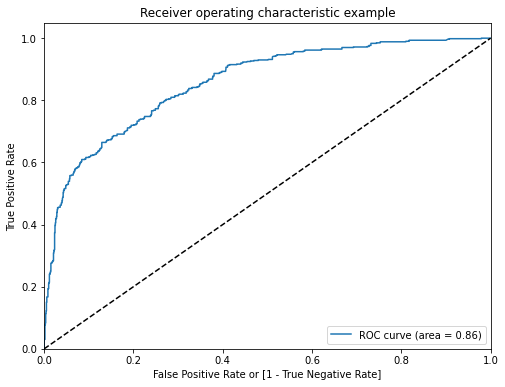

In [39]:
_, _, _, _ = draw_roc_curve( radm_clf, test_X, test_y );

In [40]:
## Configuring parameters and values for searched
tuned_parameters = [{'max_depth': [10, 15],
'n_estimators': [10,20],
'max_features': ['sqrt', 'auto']}]

## Initializing the RF classifier
radm_clf = RandomForestClassifier()

## Configuring search with the tunable parameters
clf = GridSearchCV(radm_clf,
tuned_parameters,
cv=5,
scoring='roc_auc')

## Fitting the training set
clf.fit(train_X, train_y )

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [10, 15],
                          'max_features': ['sqrt', 'auto'],
                          'n_estimators': [10, 20]}],
             scoring='roc_auc')

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

#### K fold cross validation

https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/

https://scikit-learn.org/stable/modules/cross_validation.html

In [41]:
clf.best_score_

0.9360470553797121

In [42]:
clf.best_params_

{'max_depth': 15, 'max_features': 'auto', 'n_estimators': 20}

In [43]:
## Initializing the Random Forest Mode with the optimal values
radm_clf = RandomForestClassifier( max_depth=15, n_estimators=20, max_features ='auto')

## Fitting the model with the training set
radm_clf.fit( train_X, train_y )

RandomForestClassifier(max_depth=15, n_estimators=20)

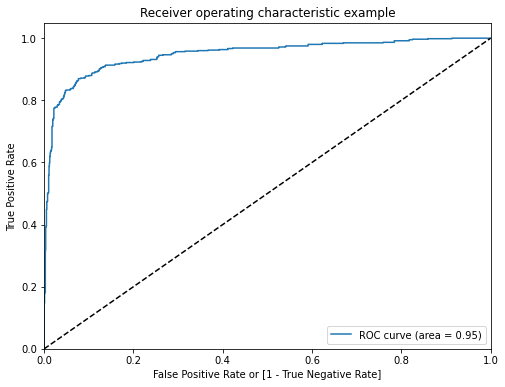

In [44]:
_, _, _, _ = draw_roc_curve( clf, test_X, test_y )

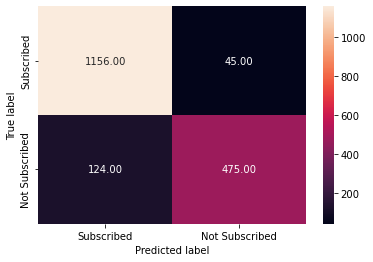

In [45]:
pred_y = radm_clf.predict( test_X )
draw_cm( test_y, pred_y )

In [46]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1201
           1       0.91      0.79      0.85       599

    accuracy                           0.91      1800
   macro avg       0.91      0.88      0.89      1800
weighted avg       0.91      0.91      0.90      1800



### Feature Importance


##### Gini Importance / Mean Decrease in Impurity (MDI)

MDI counts the times a feature is used to split a node, weighted by the number of samples it splits:

Gini Importance or Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) that include the feature, proportionally to the number of samples it splits.

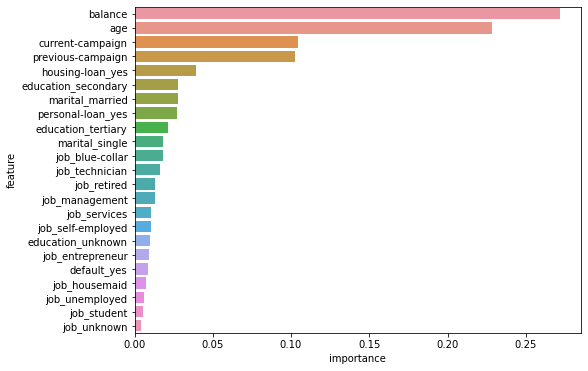

In [47]:
import numpy as np

# Create a dataframe to store the featues and their corresponding importances
feature_rank = pd.DataFrame( { 'feature': train_X.columns,
'importance': radm_clf.feature_importances_ } )

## Sorting the features based on their importances with most important feature at top.
feature_rank = feature_rank.sort_values('importance', ascending = False)
plt.figure(figsize=(8, 6))

# plot the values
sn.barplot( y = 'feature', x = 'importance', data = feature_rank );

In [48]:
feature_rank['cumsum'] = feature_rank.importance.cumsum() * 100
feature_rank.head(10)

,feature,importance,cumsum
1,balance,0.271713,27.171303
0,age,0.228241,49.995356
2,current-campaign,0.104162,60.411604
3,previous-campaign,0.102538,70.665380
21,housing-loan_yes,0.039146,74.579979
17,education_secondary,0.027964,77.376357
15,marital_married,0.027854,80.161720
22,personal-loan_yes,0.027319,82.893597
18,education_tertiary,0.021236,85.017186
16,marital_single,0.018035,86.820660
